**Goal: <br>Explore the concept of bias through data on Wikipedia articles - specifically, articles on political figures from a variety of countries**

In [234]:
# Import necessary librarires
import json
import requests
import pandas as pd
import numpy as np
from matplotlib.axis import Axis  
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [272]:
import os
ospath = os.path.abspath("__file__")
currentDir = os.path.dirname(ospath)
data_path = currentDir + '\\..\\data\\'
result_path =currentDir + '\\..\\result\\'

os.makedirs(os.path.dirname(data_path), exist_ok=True) 
os.makedirs(os.path.dirname(result_path), exist_ok=True) 

print("data_path:", data_path)
print("result_path:", result_path)

fontsize = 10

data_path: C:\UW\512\data-512-a2\code\..\data\
result_path: C:\UW\512\data-512-a2\code\..\result\


# Step 1: Getting the Article and Population Data

* Article data from [politicians by country dataset](https://figshare.com/articles/dataset/Untitled_Item/5513449)
* population data from [WPDS_2020_data.csv](https://docs.google.com/spreadsheets/d/1CFJO2zna2No5KqNm9rPK5PCACoXKzb-nycJFhV689Iw/edit?usp=sharing). It is sourced from [world population data sheet](https://www.prb.org/international/indicator/population/table/)

In [236]:
page_data = pd.read_csv(data_path + 'page_data.csv', sep=','  )
world_Population = pd.read_csv(data_path + 'WPDS_2020_data.csv', sep=',' ,keep_default_na=False )

In [262]:
page_data.head(10)

,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409
5,Template:Nigeria-politician-stub,Nigeria,391862819
6,Template:Colombia-politician-stub,Colombia,391863340
7,Template:Chile-politician-stub,Chile,391863361
8,Template:Fiji-politician-stub,Fiji,391863617
9,Template:Solomons-politician-stub,Solomon Islands,391863809


# Step 2: Cleaning the Data
* page_data.csv: Exclude page names that start with "Template:"
* population data: Keep country & SubRegion mapping 
* population data: filter out all regional population count and keep only country type data. We can only use country name to join with article (page_data.csv) data 

In [238]:
page_data_clean = page_data[~page_data["page"].str.startswith("Template:")]
rev_id_List = page_data_clean["rev_id"]

In [239]:
world_Population['index'] = world_Population.index
subRejoins = world_Population[world_Population["Type"] == "Sub-Region"].groupby(['Name'])['index'].agg("max").sort_values('index').reset_index()

def getRegion(ci):
    subRegion =  ((subRejoins[subRejoins['index'] <= ci ].sort_values('index',ascending = False).head(1)['Name']).values)
    return subRegion[0] if subRegion.size > 0 else None
world_Population.loc[:,'sub_region'] = world_Population.apply(lambda x: getRegion(x['index']),axis = 1)
country_Population = world_Population[world_Population["Type"] == "Country"]
country_Population.sort_values('Population',ascending = False).head(2)

,FIPS,Name,Type,TimeFrame,Data (M),Population,index,sub_region
158,CN,China,Country,2019,1402.385,1402385000,158,EAST ASIA
139,IN,India,Country,2019,1400.100,1400100000,139,SOUTH ASIA


# Step 3: Getting Article Quality Predictions
* Get the predicted quality scores for each article in the Wikipedia dataset using a machine learning system called ORES
* The article quality estimates are, from best to worst:
    * FA - Featured article
    * GA - Good article
    * B - B-class article
    * C - C-class article
    * Start - Start-class article
    * Stub - Stub-class article
* Using (ORES REST API)[https://ores.wikimedia.org/v3/#!/scoring/get_v3_scores_context_revid_model] get the prediction. 
* API parameters: revision Id (rev_id from page_data set) , model ("articlequality")
* capture API return value - "prediction"
* you can send multiple rev_ids as batch to get response (based on expirement 50 rev_ids in one batch is best option)

In [11]:
def api_getRevIdInfo(url, rev_id_list):
    call = requests.get(url.format(rev_id=rev_id_list))
    response = call.json()
    
    return response

In [ ]:
url = 'https://ores.wikimedia.org/v3/scores/enwiki?models=articlequality&revids={rev_id}'
binSize = 50
rev_id_List_bins = ["|".join(str(x) for x in rev_id_List[i*binSize:(i+1)*binSize]) for i in range(int((len(rev_id_List)-1)/binSize)+1)]
#len(x[1].split('|'))
len(rev_id_List_bins)

In [ ]:
ORES_prediction = []
for rev_id_List_bin in rev_id_List_bins:
    ORES_response = api_getRevIdInfo(url, rev_id_List_bin)
    #print(ORES_response)
    rev_id_pred = [ (i, "NA" if "error" in j["articlequality"] else j["articlequality"]["score"]["prediction"]) for i, j in ORES_response["enwiki"]["scores"].items()]
    ORES_prediction.extend(rev_id_pred)
df_ORES_prediction = pd.DataFrame(ORES_prediction, columns = ["rev_id","prediction"])
df_ORES_prediction = pd.DataFrame(ORES_prediction, columns = ["rev_id","prediction"])
df_ORES_prediction.to_csv( data_path + 'rev_id_predictions.csv', sep=',', index = False, header = True)

In [20]:
# Read processed data from this project 
df_ORES_prediction = pd.read_csv(data_path + 'rev_id_predictions.csv', sep=','  )

In [23]:
df_ORES_prediction.groupby(['prediction']).agg("count")

,rev_id
prediction,
B,726
C,5929
FA,290
GA,771
Start,14499
Stub,24210


# Step 4: Combining the Datasets

* Merge the wikipedia data and population data together using country field
* Exclude not matching records - either population dataset does not have an entry for the equivalent Wikipedia country, or vise versa. Output them to wp_wpds_countries-no_match.csv
* Output final data set to wp_wpds_politicians_by_country.csv
* Final data set schema: 
    * country
    * article_name
    * revision_id
    * article_quality_est
    * population

In [31]:
wp_wpds_country = page_data_clean.merge(country_Population, left_on='country',right_on = 'Name', how='outer') \
    .merge(df_ORES_prediction, left_on='rev_id',right_on = 'rev_id', how='outer')  

wp_wpds_country = wp_wpds_country[["country","page","rev_id","prediction","Population"]]
    #.set_axis(['country', 'article_name', 'revision_id', 'article_quality_est', 'population'], axis=1, inplace=True)
wp_wpds_country.columns = ['country', 'article_name', 'revision_id', 'article_quality_est', 'population']

wp_wpds_countries_no_match = wp_wpds_country[wp_wpds_country["country"].isna() | wp_wpds_country["population"].isna() ]
wp_wpds_politicians_by_country = wp_wpds_country[ ~(wp_wpds_country["country"].isna() | wp_wpds_country["population"].isna()) ]


#wp_wpds_country.to_csv( data_path + 'wp_wpds_country.csv', sep=',', index = False, header = True)
wp_wpds_countries_no_match.to_csv( data_path + 'wp_wpds_countries_no_match.csv', sep=',', index = False, header = True)
wp_wpds_politicians_by_country.to_csv( data_path + 'wp_wpds_politicians_by_country.csv', sep=',', index = False, header = True)

wp_wpds_country.dtypes

country                 object
article_name            object
revision_id            float64
article_quality_est     object
population             float64
dtype: object

In [36]:
wp_wpds_politicians_by_country = pd.read_csv(data_path + 'wp_wpds_politicians_by_country.csv', sep=','  )
wp_wpds_politicians_by_country.head()

,country,article_name,revision_id,article_quality_est,population
0,Chad,Bir I of Kanem,355319463.0,Stub,16877000.0
1,Chad,Abdullah II of Kanem,498683267.0,Stub,16877000.0
2,Chad,Salmama II of Kanem,565745353.0,Stub,16877000.0
3,Chad,Kuri I of Kanem,565745365.0,Stub,16877000.0
4,Chad,Mohammed I of Kanem,565745375.0,Stub,16877000.0


# Step 5: Analysis

* For analysis include sub-region
* Find high quality articles using prediction value (high quality article if prediction is FA or GA)
* Calculate percentage of articles-per-population using [total articles from a country]/[country population] <br> Ex: if a country has a population of 10,000 people, and you found 10 articles about politicians from that country, then the percentage of articles-per-population would be .1%.
* Calculate percentage of high-quality articles-per-population using [high-quality articles from a country]/[country population] <br>Ex: if a country with 10,000 population has 10 articles about politicians, and 2 of them are FA or GA class articles, then the percentage of high-quality articles would be 20%


In [35]:
wp_wpds_politicians_by_country_subregion = wp_wpds_politicians_by_country.merge(country_Population[['Name', 'sub_region']], left_on='country',right_on = 'Name', how='left')
wp_wpds_politicians_by_country_subregion.head(1)

,country,article_name,revision_id,article_quality_est,population,Name,sub_region
0,Chad,Bir I of Kanem,355319463.0,Stub,16877000.0,Chad,MIDDLE AFRICA


In [37]:
wp_wpds_politicians_by_country_subregion.loc[:,'is_high_quality_article'] =  np.where((wp_wpds_politicians_by_country_subregion['article_quality_est'] == "GA") | (wp_wpds_politicians_by_country_subregion['article_quality_est'] == "FA"),True,False)
wp_wpds_politicians_by_country_subregion.dtypes

country                     object
article_name                object
revision_id                float64
article_quality_est         object
population                 float64
Name                        object
sub_region                  object
is_high_quality_article       bool
dtype: object

In [56]:
wp_wpds_politicians_by_country.count()

country                44842
article_name           44842
revision_id            44842
article_quality_est    44568
population             44842
dtype: int64

In [91]:
df_group = wp_wpds_politicians_by_country_subregion.groupby(['country','sub_region','is_high_quality_article','population'])['revision_id'].count().rename("article_count").reset_index()
df_group.loc[:,'high_quality_article_count'] =  np.where(df_group['is_high_quality_article'] ,df_group['article_count'],0)
df_group.loc[:,'low_quality_article_count'] =  np.where(~df_group['is_high_quality_article'] ,df_group['article_count'],0)
df_group = df_group.groupby(['country','sub_region','population'])['high_quality_article_count','low_quality_article_count'].sum().reset_index()
df_group.loc[:,'total_articles_count'] = df_group['high_quality_article_count'] + df_group['low_quality_article_count']
df_group.loc[:,'total_articles_percentage_per_population'] = df_group['total_articles_count']/df_group['population']
df_group.loc[:,'high_quality_articles_percentage_per_population'] = df_group['high_quality_article_count']/df_group['population']

df_group.style.hide_index()
display(df_group.sort_values('high_quality_articles_percentage_per_population',ascending = True).head(2))

,country,sub_region,population,high_quality_article_count,low_quality_article_count,total_articles_count,total_articles_percentage_per_population,high_quality_articles_percentage_per_population
54,Finland,Channel Islands,5529000.0,0,570,570,0.000103,0.0
36,Comoros,EASTERN AFRICA,870000.0,0,51,51,0.000059,0.0


# Step 6: Results

## Q1: Top 10 countries by coverage: 10 highest-ranked countries in terms of number of politician articles as a proportion of country population

In [273]:
Q1_top10 = df_group[['country','total_articles_percentage_per_population']].sort_values('total_articles_percentage_per_population',ascending = False).head(10)
Q1_top10.to_csv( result_path + 'Q1_Top10_CountriesByCoverage.csv', sep=',', index = False, header = True)
display(Q1_top10)

,country,total_articles_percentage_per_population
169,Tuvalu,0.005400
117,Nauru,0.004727
138,San Marino,0.002382
110,Monaco,0.001053
95,Liechtenstein,0.000718
104,Marshall Islands,0.000649
164,Tonga,0.000636
70,Iceland,0.000549
3,Andorra,0.000415
52,Federated States of Micronesia,0.000340


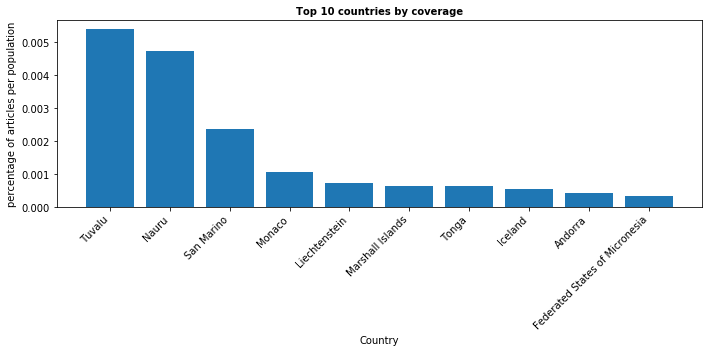

In [188]:
#Q1_top10.plot.bar(x = 'country', y = 'total_articles_percentage_per_population',rot=45)
plt.figure(figsize=(10,5))
plt.bar(Q1_top10['country'], Q1_top10['total_articles_percentage_per_population'] )
plt.xticks(rotation=45,ha='right',fontsize=fontsize)
plt.title("Top 10 countries by coverage",fontweight="bold",fontsize=fontsize)
plt.xlabel("Country",fontsize=fontsize)
plt.ylabel("percentage of articles per population",fontsize=fontsize);


plt.tight_layout()
plt.show()

## Q2: Bottom 10 countries by coverage: 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population

In [275]:
Q2_top10 = df_group[['country','total_articles_percentage_per_population']].sort_values('total_articles_percentage_per_population',ascending = True).head(10)
Q2_top10.to_csv( result_path + 'Q2_Bottom10_CountriesByCoverage.csv', sep=',', index = False, header = True)
Q2_top10 

,country,total_articles_percentage_per_population
71,India,7.035212e-07
72,Indonesia,7.764804e-07
34,China,8.079094e-07
176,Uzbekistan,8.193363e-07
51,Ethiopia,8.789029e-07
181,Zambia,1.359878e-06
84,"Korea, North",1.396486e-06
162,Thailand,1.683350e-06
114,Mozambique,1.861002e-06
13,Bangladesh,1.890359e-06


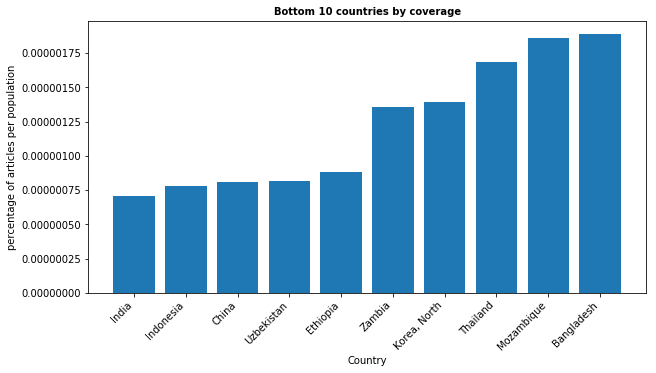

In [190]:
plt.figure(figsize=(10,5))
plt.bar(Q2_top10['country'], Q2_top10['total_articles_percentage_per_population'] )
plt.xticks(rotation=45,ha='right',fontsize=fontsize)
plt.title("Bottom 10 countries by coverage",fontweight="bold",fontsize=fontsize)
plt.xlabel("Country",fontsize=fontsize)
plt.ylabel("percentage of articles per population",fontsize=fontsize);
plt.show()

## Q3: Top 10 countries by relative quality: 10 highest-ranked countries in terms of the relative proportion of politician articles that are of GA and FA-quality

In [276]:
Q3_top10 = df_group[['country','high_quality_articles_percentage_per_population']].sort_values('high_quality_articles_percentage_per_population',ascending = False).head(10)
Q3_top10.to_csv( result_path + 'Q3_Top10_CountriesByRelativeQuality.csv', sep=',', index = False, header = True)
display(Q3_top10)

,country,high_quality_articles_percentage_per_population
169,Tuvalu,0.000400
44,Dominica,0.000014
177,Vanuatu,0.000009
70,Iceland,0.000005
75,Ireland,0.000005
112,Montenegro,0.000003
105,Martinique,0.000003
19,Bhutan,0.000003
120,New Zealand,0.000003
135,Romania,0.000002


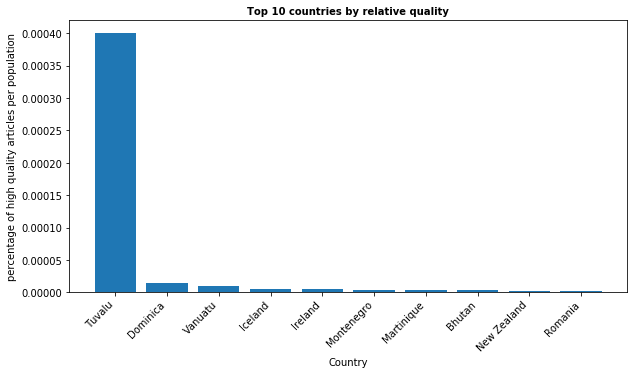

In [193]:
plt.figure(figsize=(10,5))
plt.bar(Q3_top10['country'], Q3_top10['high_quality_articles_percentage_per_population'] )
plt.xticks(rotation=45,ha='right',fontsize=fontsize)
plt.title("Top 10 countries by relative quality",fontweight="bold",fontsize=fontsize)
plt.xlabel("Country",fontsize=fontsize)
plt.ylabel("percentage of high quality articles per population",fontsize=fontsize);
plt.show()

## Q4: Bottom 10 countries by relative quality: 10 lowest-ranked countries in terms of the relative proportion of politician articles that are of GA and FA-quality

In [277]:
Q4_top10 = df_group[['country','high_quality_articles_percentage_per_population']].sort_values('high_quality_articles_percentage_per_population',ascending = True).head(10)
Q4_top10.to_csv( result_path + 'Q4_Bottom10_CountriesByRelativeQuality.csv', sep=',', index = False, header = True)
Q4_top10

,country,high_quality_articles_percentage_per_population
54,Finland,0.0
36,Comoros,0.0
38,Costa Rica,0.0
43,Djibouti,0.0
49,Eritrea,0.0
50,Estonia,0.0
52,Federated States of Micronesia,0.0
56,French Guiana,0.0
148,Solomon Islands,0.0
62,Grenada,0.0


In [233]:
set.intersection(set(country_Population.sort_values('Population',ascending = False).head(20)['Name'])
                 ,set(Q4_top10['country']))

set()

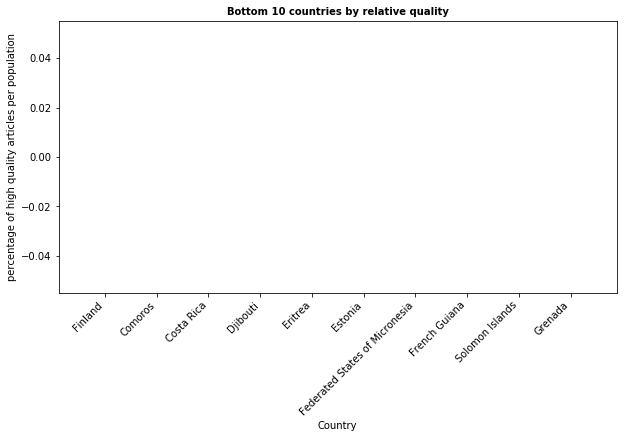

In [195]:
plt.figure(figsize=(10,5))
plt.bar(Q4_top10['country'], Q4_top10['high_quality_articles_percentage_per_population'] )
plt.xticks(rotation=45,ha='right',fontsize=fontsize)
plt.title("Bottom 10 countries by relative quality",fontweight="bold",fontsize=fontsize)
plt.xlabel("Country",fontsize=fontsize)
plt.ylabel("percentage of high quality articles per population",fontsize=fontsize);
plt.show()

## Q5: Geographic regions by coverage: Ranking of geographic regions (in descending order) in terms of the total count of politician articles from countries in each region as a proportion of total regional population

In [85]:
df_group_subregion = df_group.groupby(['sub_region'])['population','high_quality_article_count','total_articles_count'].sum().reset_index()
df_group_subregion.loc[:,'total_articles_percentage_per_population'] = df_group_subregion['total_articles_count']/df_group_subregion['population']
df_group_subregion.loc[:,'high_quality_articles_percentage_per_population'] = df_group_subregion['high_quality_article_count']/df_group_subregion['population']
df_group_subregion.head(1)


,sub_region,population,high_quality_article_count,total_articles_count,total_articles_percentage_per_population,high_quality_articles_percentage_per_population
0,CARIBBEAN,39056000.0,13,697,0.000018,3.328554e-07


In [278]:
Q5 = df_group_subregion[['sub_region','total_articles_percentage_per_population']].sort_values('total_articles_percentage_per_population',ascending = False)
Q5.to_csv( result_path + 'Q5_GeographicRegionsByCoverage.csv', sep=',', index = False, header = True)
Q5

,sub_region,total_articles_percentage_per_population
10,OCEANIA,0.000075
3,Channel Islands,0.000036
15,SOUTHERN EUROPE,0.000025
18,WESTERN EUROPE,0.000023
0,CARIBBEAN,0.000018
6,EASTERN EUROPE,0.000013
14,SOUTHERN AFRICA,0.000010
1,CENTRAL AMERICA,0.000010
17,WESTERN ASIA,0.000009
7,MIDDLE AFRICA,0.000007


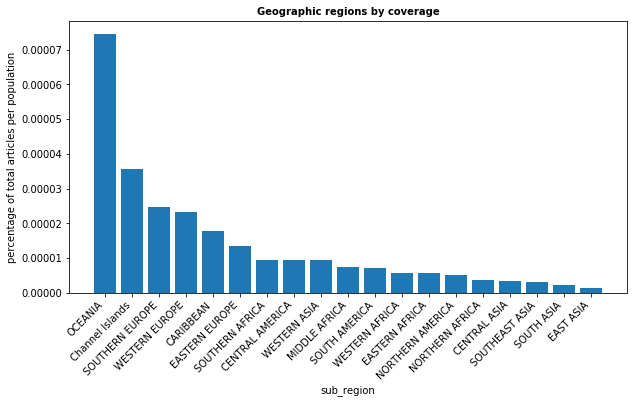

In [197]:
#Q1_top10.plot.bar(x = 'country', y = 'total_articles_percentage_per_population',rot=45)
plt.figure(figsize=(10,5))
plt.bar(Q5['sub_region'], Q5['total_articles_percentage_per_population'] )
plt.xticks(rotation=45,ha='right',fontsize=fontsize)
plt.title("Geographic regions by coverage",fontweight="bold",fontsize=fontsize)
plt.xlabel("sub_region",fontsize=fontsize)
plt.ylabel("percentage of total articles per population",fontsize=fontsize);
plt.show()

## Q6: Geographic regions by coverage: Ranking of geographic regions (in descending order) in terms of the relative proportion of politician articles from countries in each region that are of GA and FA-quality

In [279]:
Q6 = df_group_subregion[['sub_region','high_quality_articles_percentage_per_population']].sort_values('high_quality_articles_percentage_per_population',ascending = False)
Q6.to_csv( result_path + 'Q6_GeographicRegionsByRelativeQuality.csv', sep=',', index = False, header = True)
Q6

,sub_region,high_quality_articles_percentage_per_population
10,OCEANIA,1.498894e-06
3,Channel Islands,9.651779e-07
15,SOUTHERN EUROPE,4.896252e-07
6,EASTERN EUROPE,4.196510e-07
0,CARIBBEAN,3.328554e-07
17,WESTERN ASIA,3.266067e-07
18,WESTERN EUROPE,2.864758e-07
9,NORTHERN AMERICA,2.825565e-07
7,MIDDLE AFRICA,1.774052e-07
1,CENTRAL AMERICA,1.417417e-07


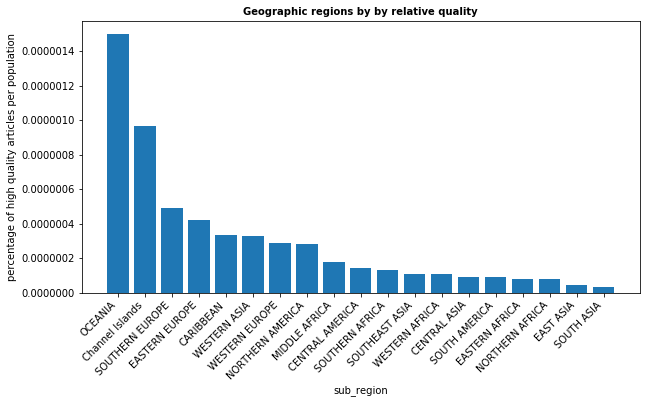

In [199]:
#Q1_top10.plot.bar(x = 'country', y = 'total_articles_percentage_per_population',rot=45)
plt.figure(figsize=(10,5))
plt.bar(Q6['sub_region'], Q6['high_quality_articles_percentage_per_population'] )
plt.xticks(rotation=45,ha='right',fontsize=fontsize)
plt.title("Geographic regions by by relative quality",fontweight="bold",fontsize=fontsize)
plt.xlabel("sub_region",fontsize=fontsize)
plt.ylabel("percentage of high quality articles per population",fontsize=fontsize);
plt.show()

# Writeup: Reflections and Implications

In [251]:
# Check how many countries with low population has intersection with Q1
set.intersection(set(country_Population.sort_values('Population',ascending = True).head(10)['Name'])
                 ,set(Q1_top10['country']))

{'Andorra',
 'Liechtenstein',
 'Marshall Islands',
 'Monaco',
 'Nauru',
 'San Marino',
 'Tuvalu'}

In [250]:
# Check how many countries with high population has intersection with Q2
set.intersection(set(country_Population.sort_values('Population',ascending = False).head(10)['Name'])
                 ,set(Q2_top10['country']))

{'Bangladesh', 'China', 'India', 'Indonesia'}

# * Above result shows top & bottom percentage of articles-per-population are mostly from countries with very low & high population. So there is relation between population and percentage of articles-per-population. 

<br>

# * Oceania & Europe region countries has high percentage of articles-per-population

<br>

# * North Amrica region countries, US (Rank 163) & Canada (Rank 69) has less percentage of articles-per-population eventhough they are well developed countries. 

<br>

# * We have many countries (~37) with out any high quality articles, thats why we see 0 percentage for Q4. 

<br>

# * We have some countries with out any articles, we excluded them from final analysis

<br><br><br>


## What biases did you expect to find in the data (before you started working with it), and why?
   * **Depends on sample data collected year we may see bias towords countries which has peak wiki usage/contribution. In our class we saw the wiki contribution/usage pattern changes over the years.**<br><br>
    
   * **Expected United States, Canada, United Kingdom, Germany or Spain will have most articles and high quality articles compare to other countries. These countries are democratic, has very high education rate and access to internet. So expected more & good quality artciles.**<br><br>
    
   * **Majority of articles might be from english speaking countries, so expevted bias in model results towords articles from english speaking countries.**<br><br>
      

## What (potential) sources of bias did you discover in the course of your data processing and analysis?
   * **We don't know politicians and population ratio. So if a country with small population and high percentage of politicians might have more articles coverage rate compare to other.** <br><br>
   * **Using Q5 & Q6 results we can see high quality articles per population are from OCEANIA and Europe regions**
   
## What might your results suggest about (English) Wikipedia as a data source?
  * **I think we don't see high quality articles for most of the countries, especially non english speaking countries due to this.**  

## What might your results suggest about the internet and global society in general?
  * **Surprisingly US & Canada is not in top 10 percentage of articles-per-population, so it shows there is no positive relation with overall internet and global society** 

## Can you think of a realistic data science research situation where using these data (to train a model, perform a hypothesis-driven research, or make business decisions) might create biased or misleading results, due to the inherent gaps and limitations of the data?


## How might a researcher supplement or transform this dataset to potentially correct for the limitations/biases you observed?
